In [1]:
from project_functions import*

# Project 2 

### Introduction

In this project we will solve a 2D advection-diffusion problem given by

\begin{equation}
    \begin{aligned}
    -\Delta u + \mathbf{v} \cdot \nabla u &= f, \quad &&0 < x,y < 1 \\
    u &= g,  \quad &&\text{on the boundary.}
    \end{aligned}
    \tag{1}
\end{equation}


To solve this problem we will use three different methods;  GMRES, multigrid V-cycle, and a preconditioned GMRES method using the multigrid V-cycle as a preconditioner. Firstly we need to develop an understanding of the problem we ar solving. For simplicity, we assume that the velocity field $\mathbf{v} = [v_1, v_2]^T \geq \mathbf{0}$, in the sence that $v_1, v_2 \geq 0$. We also use an equidistant grid with stepsize $h = \frac{1}{N}$, such that $u_{i,j} = u(x_i,y_j) = u(ih,jh)$ and similarly for $f_{i,j}$. For the discretization of the problem we use a 5-point stencil for the diffusion term and an upwind scheme for the advection term, hence we get the following formula

\begin{equation}
    \begin{aligned}
        (4U_{i,j}- U_{i+1,j} - U_{i-1,j} -U_{i,j+1} -U_{i,j-1}) + hv_1(U_{i,j} - U_{i-1,j}) + hv_2(U_{i,j} - U_{i,j-1}) =  h^2f_{i,j}.
    \end{aligned}
    \tag{2}
\end{equation}{eq}`eq:2`

For simplicity we choose $\mathbf{v} = [1,1]$ and an excact solution $u(x,y) = \sin(\pi x)\sin(2\pi y)$. By balancing the equation using (1) we get that the right hand sides becomes 

\begin{equation}
    \begin{aligned}
       f(x,y) &= -\Delta u + \mathbf{v} \cdot \nabla u = 5\pi^2 \sin(\pi x)\sin(2\pi y) + \pi \cos(\pi x)\sin(2\pi y) + 2\pi \sin(\pi x)\cos(2\pi y) \\
       g &= 0
    \end{aligned}
    \tag{3}
\end{equation}

Since we are working with a discretization of a PDE we do not have the matrix $A$ directly, hence we want to compute the matrix vector product instead working directly on the grid. This is given by the left hand side of equation $(1)$. Thus we make functions lhs_func() and rhs_func() which computes repectively the left hand side and right hand side of equation. Then we can use scipy.sparce.gmres to compute solutions for different values of $N = 2^5, 2^6, 2^7, 2^8$.

In [3]:
N_arr = np.array((2**5, 2**6, 2**7, 2**8))
u_arr_scipy = []
time_arr_scipy = []
it_arr_scipy = []
for N in N_arr:
    u0 = np.zeros((N+1,N+1))  #Start with the zero matrix
    rhs = rhs_func(N)
    start = perf_counter()
    u, it = solve_scipy_gmres(u0, rhs, N, v=np.array([1, 1]), tol=1e-6)
    time = perf_counter() - start
    time_arr_scipy.append(time)
    it_arr_scipy.append(it)
    u_arr_scipy.append(u)

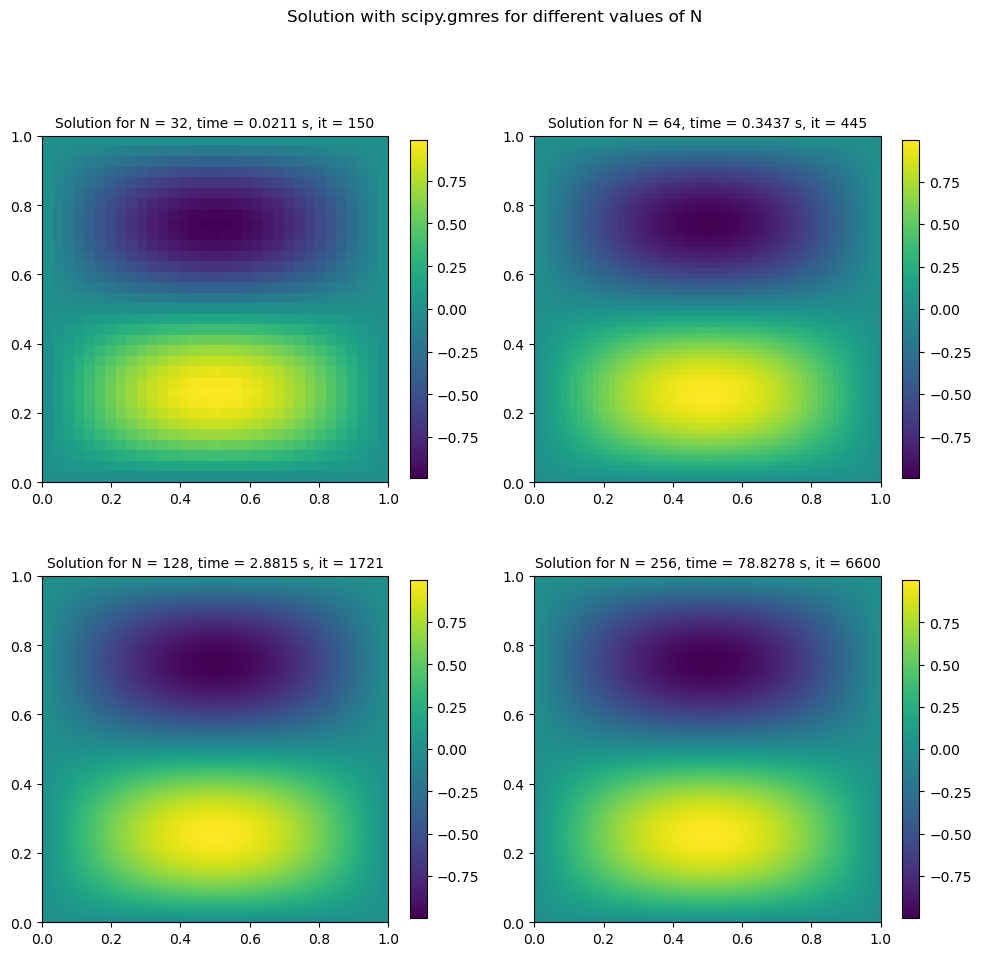

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle('Solution with scipy.gmres for different values of N')

im0 = ax[0][0].imshow(u_arr_scipy[0][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im0, ax=ax[0][0], shrink = 0.75)
im1 = ax[0][1].imshow(u_arr_scipy[1][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im1, ax=ax[0][1], shrink = 0.75) 
im2 = ax[1][0].imshow(u_arr_scipy[2][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im2, ax=ax[1][0], shrink = 0.75)
im3 = ax[1][1].imshow(u_arr_scipy[3][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im3, ax=ax[1][1], shrink = 0.75) 

ax[0][0].set_title(f'Solution for N = {N_arr[0]}, time = {time_arr_scipy[0]:.4f} s, it = {it_arr_scipy[0]}', fontsize = 10)
ax[0][1].set_title(f'Solution for N = {N_arr[1]}, time = {time_arr_scipy[1]:.4f} s, it = {it_arr_scipy[1]}', fontsize = 10)
ax[1][0].set_title(f'Solution for N = {N_arr[2]}, time = {time_arr_scipy[2]:.4f} s, it = {it_arr_scipy[2]}', fontsize = 10)
ax[1][1].set_title(f'Solution for N = {N_arr[3]}, time = {time_arr_scipy[3]:.4f} s, it = {it_arr_scipy[3]}', fontsize = 10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()


We observe from the plots that the GMRES seems to converge fast for small grid sizes $N$, but convergence time increases rapidly as $N$ increases. Further we want to implement our own restarted GMRES algorithm for the advection-diffusion problem, which is implemented in project_functions.py. In the code block below we test our algorithm on the same grid sizes as previously.

In [65]:
N_arr = np.array((2**5, 2**6, 2**7, 2**8))
m = 10
u_arr_gmres = []
time_arr_gmres = []
it_arr_gmres = []
res_arr_gmres = []
for N in N_arr:
    u0 = np.zeros((N+1,N+1))  #Start with the zero matrix
    rhs = rhs_func(N)
    u, res_arr, count, time = restarted_gmres(u0, rhs,m , N, v=np.array([1, 1]), tol=1e-6)
    res_arr_gmres.append(res_arr)
    time_arr_gmres.append(time)
    it_arr_gmres.append(count)
    u_arr_gmres.append(u)

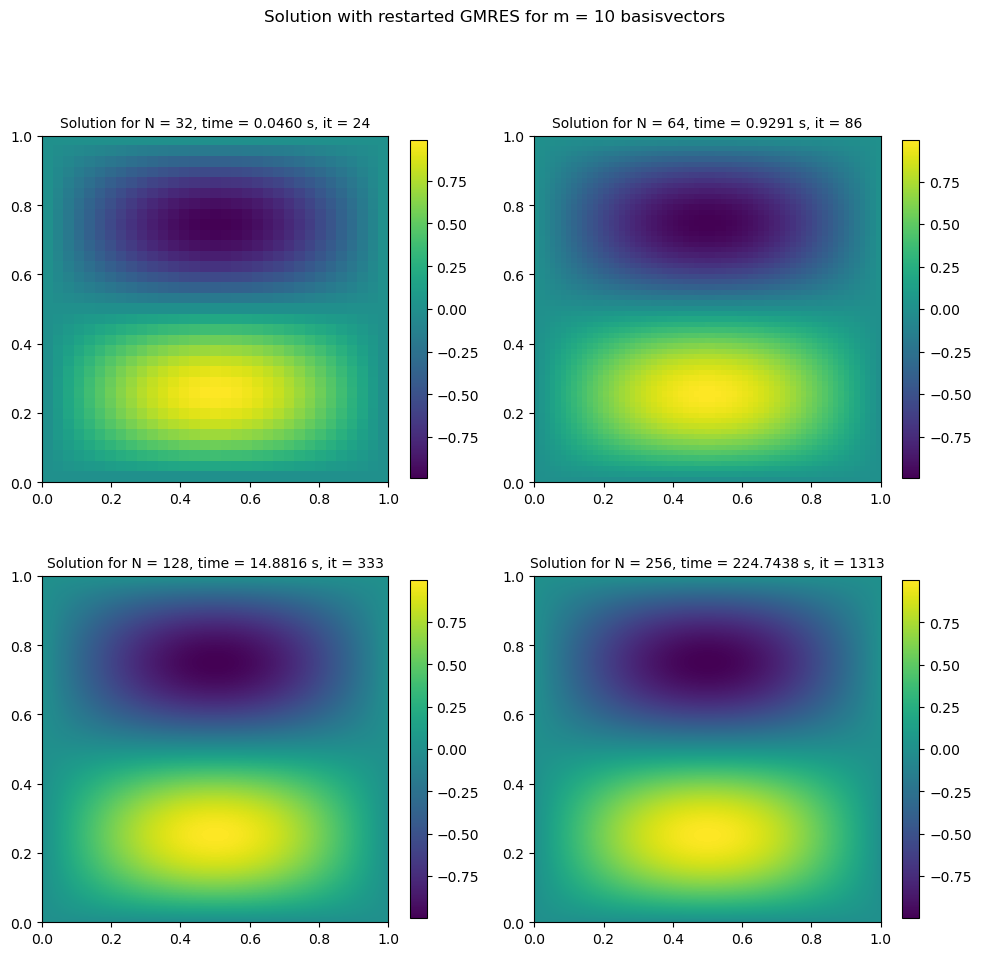

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle('Solution with restarted GMRES for m = 10 basisvectors')

im0 = ax[0][0].imshow(u_arr_gmres[0][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im0, ax=ax[0][0], shrink = 0.75)
im1 = ax[0][1].imshow(u_arr_gmres[1][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im1, ax=ax[0][1], shrink = 0.75) 
im2 = ax[1][0].imshow(u_arr_gmres[2][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im2, ax=ax[1][0], shrink = 0.75)
im3 = ax[1][1].imshow(u_arr_gmres[3][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im3, ax=ax[1][1], shrink = 0.75) 

ax[0][0].set_title(f'Solution for N = {N_arr[0]}, time = {time_arr_gmres[0]:.4f} s, it = {it_arr_gmres[0]}', fontsize = 10)
ax[0][1].set_title(f'Solution for N = {N_arr[1]}, time = {time_arr_gmres[1]:.4f} s, it = {it_arr_gmres[1]}', fontsize = 10)
ax[1][0].set_title(f'Solution for N = {N_arr[2]}, time = {time_arr_gmres[2]:.4f} s, it = {it_arr_gmres[2]}', fontsize = 10)
ax[1][1].set_title(f'Solution for N = {N_arr[3]}, time = {time_arr_gmres[3]:.4f} s, it = {it_arr_gmres[3]}', fontsize = 10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()


We observe from the plots that the algorithm converge in fewer iterations than scipy's GMRES, however our algorithm is slower with regard to time. Concerning the iterations we might get fewer iterations because of the number of basisvectors $m$, if the number of basisvectors is decreased we will probably need more iterations to converge. Concerning the time to converge scipy has implemented some smart algorithm for choosing $m$ correctly and a optimized algorithm for creating the basisvectors. Now we want to compare our numerical solution to the exact solution for $N = 2^8$, as well as the solution found using scipy.

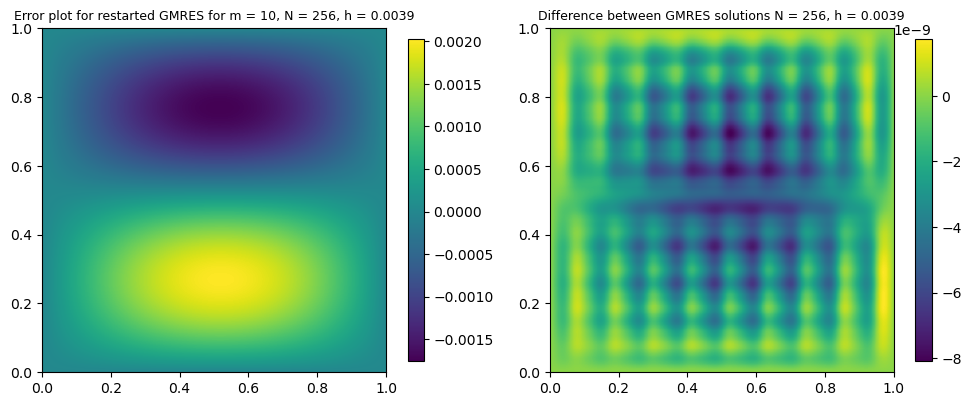

In [50]:
err_gmres = u_exact(N_arr[3]) - u_arr_gmres[3]
err_scipy = u_arr_scipy[3] - u_arr_gmres[3]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,10))

im0 = ax[0].imshow(err_gmres[::-1,:], extent=[0, 1, 0, 1])
fig.colorbar(im0, ax=ax[0], shrink = 0.35)
im1 = ax[1].imshow(err_scipy[::-1,:], extent=[0, 1, 0, 1])
fig.colorbar(im1, ax=ax[1], shrink = 0.35)

ax[0].set_title(f"Error plot for restarted GMRES for m = {m}, N = {N_arr[3]}, h = {1/N_arr[3]:.4f}", fontsize = 9)
ax[1].set_title(f"Difference between GMRES solutions N = {N_arr[3]}, h = {1/N_arr[3]:.4f}", fontsize = 9)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the titl
plt.show()

From the plot on the left we observe that the maximal error has an approximate value of $0.0020$ which is less than the stepsize $h \approx 0.0039$. This is reasonable result as the scheme is of order $o(h)$. From the plot on the right hand side we observe that the two numerical solutions are bascicly the same with a difference of order $10^{-9}$. This shows that our implementation of the restarted GMRES is sufficient. 

Further we implement a multigrid method for solving the method. This is done by restrict the fine grid down to a coarser level, then solve the coarse system using the restarted GMRES algorithm before interpolating the results back to the fine grid. Then using this interpolated result as a initial guess for the solution and rerun the function we slowly converge to a solution. This is implemented in the codeblock below.

In [145]:
#Check convergence for different number of pre and post smoothings
N = 2**6
v = np.array((1,1))
u0 = np.random.random((N+1,N+1))
u0[-1,:] = u0[0,:] = u0[:,-1] = u0[:,0] = 0
rhs = rhs_func(N,v = v)
m = 10
tol = 1e-6
nu1_arr_mgv = np.array((2,10,50,100, 200, 1000))
nu2_arr_mgv = np.array((2,10,50,100, 200, 1000))

res_arr_mgv = []
count_arr_mgv = []
time_arr_mgv = []
u_arr_mgv = []

for i in range(len(nu1_arr_mgv)):
    start = perf_counter()
    u_mgv = mgv(u0, rhs, m, N, nu1 = nu1_arr_mgv[i], nu2 = nu2_arr_mgv[i], level = 1, max_level= 3, v= v)
    r_k1 = rhs_func(N, v = v) - lhs_func(u_mgv,N, v = v) 
    count = 1
    res_arr_mgv_loop = [np.linalg.norm(r_k1)]    
    while np.linalg.norm(r_k1) > tol:
        u_mgv = mgv(u_mgv, rhs, m, N, nu1 = nu1_arr_mgv[i], nu2 = nu2_arr_mgv[i], level = 1, max_level= 3, v = v)
        r_k1 = rhs_func(N, v = v) - lhs_func(u_mgv,N, v = v) 
        res_arr_mgv_loop.append(np.linalg.norm(r_k1))
        count += 1
        print(np.linalg.norm(r_k1),count, end = '\r')

    time = perf_counter() - start
    u_arr_mgv.append(u_mgv)
    res_arr_mgv.append(res_arr_mgv_loop)
    count_arr_mgv.append(count)
    time_arr_mgv.append(time)
    

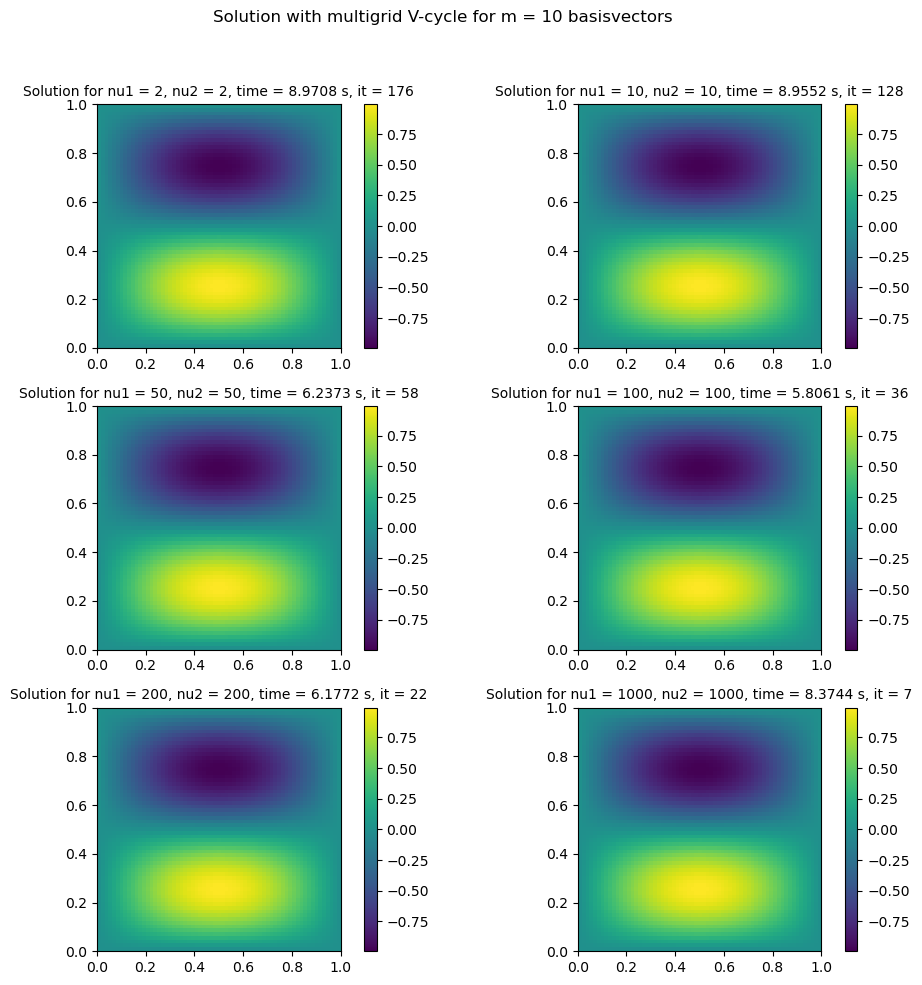

In [146]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig.suptitle('Solution with multigrid V-cycle for m = 10 basisvectors')

im0 = ax[0][0].imshow(u_arr_mgv[0][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im0, ax=ax[0][0], shrink = 1)
im1 = ax[0][1].imshow(u_arr_mgv[1][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im1, ax=ax[0][1], shrink = 1) 
im2 = ax[1][0].imshow(u_arr_mgv[2][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im2, ax=ax[1][0], shrink = 1)
im3 = ax[1][1].imshow(u_arr_mgv[3][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im3, ax=ax[1][1], shrink = 1) 
im4 = ax[2][0].imshow(u_arr_mgv[4][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im4, ax=ax[2][0], shrink = 1)
im5 = ax[2][1].imshow(u_arr_mgv[5][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im5, ax=ax[2][1], shrink = 1)

ax[0][0].set_title(f'Solution for nu1 = {nu1_arr_mgv[0]}, nu2 = {nu2_arr_mgv[0]}, time = {time_arr_mgv[0]:.4f} s, it = {count_arr_mgv[0]}', fontsize = 10)
ax[0][1].set_title(f'Solution for nu1 = {nu1_arr_mgv[1]}, nu2 = {nu2_arr_mgv[1]}, time = {time_arr_mgv[1]:.4f} s, it = {count_arr_mgv[1]}', fontsize = 10)
ax[1][0].set_title(f'Solution for nu1 = {nu1_arr_mgv[2]}, nu2 = {nu2_arr_mgv[2]}, time = {time_arr_mgv[2]:.4f} s, it = {count_arr_mgv[2]}', fontsize = 10)
ax[1][1].set_title(f'Solution for nu1 = {nu1_arr_mgv[3]}, nu2 = {nu2_arr_mgv[3]}, time = {time_arr_mgv[3]:.4f} s, it = {count_arr_mgv[3]}', fontsize = 10)
ax[2][0].set_title(f'Solution for nu1 = {nu1_arr_mgv[4]}, nu2 = {nu2_arr_mgv[4]}, time = {time_arr_mgv[4]:.4f} s, it = {count_arr_mgv[4]}', fontsize = 10)
ax[2][1].set_title(f'Solution for nu1 = {nu1_arr_mgv[5]}, nu2 = {nu2_arr_mgv[5]}, time = {time_arr_mgv[5]:.4f} s, it = {count_arr_mgv[5]}', fontsize = 10)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()


From the plots we observe that a higher amount of pre- and post-smoothing gives in general fewer iterations, but it can increase in computation time when too large. The reason that higher pre- and post-smoothing gives fewer iterations is that the input matrix $u$ is closer to the solution $u^*$, since the jacobi algorithm converges to $u^*$. However it takes time to do many pre- and post- smoothings so the total computational time increases as the number of smoothing operations becomes too large.

Now we want to compare convergnce for a fixed number of smoothings for different grid sizes. As before wee us $N = 2^5, 2^6, 2^7, 2^8$, and from the plots above we choose pre- and post- smoothings numbers to be nu1 = nu2 = $100$.

In [147]:
#Check convergence for different number of pre and post smoothings
N_arr = np.array((2**5,2**6,2**7,2**8))
v = np.array((1,1))
m = 10
nu1 = 100
nu2 = 100
tol = 1e-6

res_arr_mgv_2 = []
count_arr_mgv_2 = []
time_arr_mgv_2 = []
u_arr_mgv_2 = []

for i, N in enumerate(N_arr):
    start = perf_counter()
    u0 = np.zeros((N+1,N+1))
    rhs = rhs_func(N,v = v)
    u_mgv = mgv(u0, rhs, m, N, nu1, nu2, level = 1, max_level= 3 + i, v= v)
    r_k1 = rhs_func(N, v = v) - lhs_func(u_mgv,N, v = v) 
    count = 1
    res_arr_mgv_loop = [np.linalg.norm(r_k1)]    
    while np.linalg.norm(r_k1) > tol:
        u_mgv = mgv(u_mgv, rhs, m, N, nu1, nu2, level = 1, max_level= 3 + i, v = v)
        r_k1 = rhs_func(N, v = v) - lhs_func(u_mgv,N, v = v) 
        res_arr_mgv_loop.append(np.linalg.norm(r_k1))
        count += 1
        print(np.linalg.norm(r_k1),count, end = '\r')

    time = perf_counter() - start
    u_arr_mgv_2.append(u_mgv)
    res_arr_mgv_2.append(res_arr_mgv_loop)
    count_arr_mgv_2.append(count)
    time_arr_mgv_2.append(time)

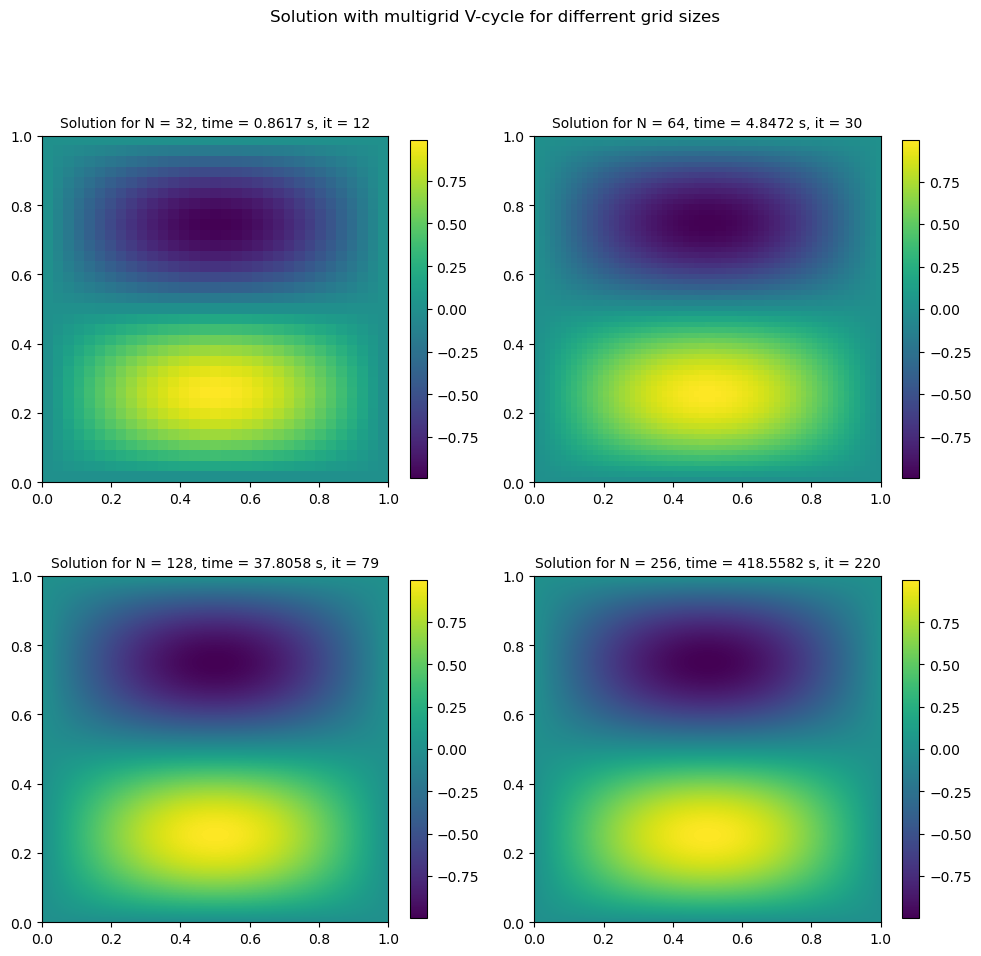

In [148]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle('Solution with multigrid V-cycle for differrent grid sizes')

im0 = ax[0][0].imshow(u_arr_mgv_2[0][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im0, ax=ax[0][0], shrink = 0.75)
im1 = ax[0][1].imshow(u_arr_mgv_2[1][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im1, ax=ax[0][1], shrink = 0.75) 
im2 = ax[1][0].imshow(u_arr_mgv_2[2][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im2, ax=ax[1][0], shrink = 0.75)
im3 = ax[1][1].imshow(u_arr_mgv_2[3][::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im3, ax=ax[1][1], shrink = 0.75) 

ax[0][0].set_title(f'Solution for N = {N_arr[0]}, time = {time_arr_mgv_2[0]:.4f} s, it = {count_arr_mgv_2[0]}', fontsize = 10)
ax[0][1].set_title(f'Solution for N = {N_arr[1]}, time = {time_arr_mgv_2[1]:.4f} s, it = {count_arr_mgv_2[1]}', fontsize = 10)
ax[1][0].set_title(f'Solution for N = {N_arr[2]}, time = {time_arr_mgv_2[2]:.4f} s, it = {count_arr_mgv_2[2]}', fontsize = 10)
ax[1][1].set_title(f'Solution for N = {N_arr[3]}, time = {time_arr_mgv_2[3]:.4f} s, it = {count_arr_mgv_2[3]}', fontsize = 10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

We observe that both the number of iterations and time for convergence increases rapidly as the grid size $N$ increases. This is not expected as multigrid should be a good solver for large grid sizes. There are many possible explenation for this: 1) Double for loops in restriction and interpolation which might be computationally slow. 2) Many pre- and post- smoothings which takes more computational time for larger grids. 3) Input parameters are porly chosen. 4) Possible implimentation errors in the functions used in the multigrid V-cycle. Even tho the multigrid converges slowly it converges allways to the analytical solution $u^*$. 

Now we want to solve a problem for a different advection-diffusion problem. We choose the new exact solution $u = x(1-x)y(1-y)$ as our new problem with the same velocity field as before, $\mathbf{v} = [1,1]^T$.

In [37]:
N = 2**6
v = np.array((1,1))
m = 10
nu1 = 10
nu2 = 10
tol = 1e-6
u0 = np.random.random((N+1,N+1))
u0[-1,:] = u0[0,:] = u0[:,-1] = u0[:,0] = 0
rhs = rhs_func_2(N)
u_ex_2 = u_exact_2(N)

start = perf_counter()
u_mgv = mgv(u0, rhs, m, N, nu1, nu2, level = 1, max_level= 3, v= v)
r_k1 = rhs_func_2(N, v = v) - lhs_func(u_mgv,N, v = v) 
count = 1
while np.linalg.norm(r_k1) > tol:
    u_mgv = mgv(u_mgv, rhs, m, N, nu1, nu2, level = 1, max_level= 3, v = v)
    r_k1 = rhs_func_2(N,v = v) - lhs_func(u_mgv,N, v = v) 
    count += 1

time = perf_counter() - start
error = u_ex_2 - u_mgv

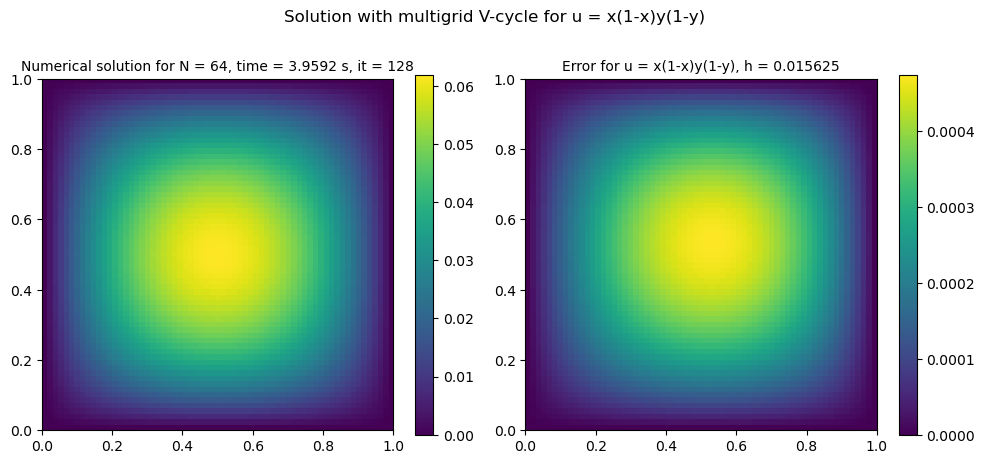

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,10))
fig.suptitle('Solution with multigrid V-cycle for u = x(1-x)y(1-y)')

im0 = ax[0].imshow(u_mgv[::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im0, ax=ax[0], shrink = 0.25)
im1 = ax[1].imshow(error[::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im1, ax=ax[1], shrink = 0.25) 

ax[0].set_title(f'Numerical solution for N = {N}, time = {time:.4f} s, it = {count}', fontsize = 10)
ax[1].set_title(f'Error for u = x(1-x)y(1-y), h = {1/N}', fontsize = 10)

plt.tight_layout(rect=[0, 0, 1, 1.5])  # Adjust layout to make room for the title
plt.show()

We observe that the algorithm converges towards the exact solution, with errors much smaller than the stepsize $h$.

Further we return to our original problem with a more dominating velocity field and space dependent velocity field. Then we want to compare convergence to our original velocity field.

In [68]:
# Define the grid size and velocity field
N = 2**6
x = np.linspace(0, 1, N + 1)
y = np.linspace(0, 1, N + 1)
X, Y = np.meshgrid(x, y)
v_x = 1 + np.cos(np.pi * X)  # Velocity component in the x-direction
v_y = 1 + np.cos(np.pi * Y)  # Velocity component in the y-direction
v = np.array([v_x, v_y])  # Combine into a single velocity field

u0 = np.zeros((N + 1, N + 1))
u0[0, :] = u0[-1, :] = u0[:, 0] = u0[:, -1] = 0  # Dirichlet boundary conditions
rhs = rhs_func_space_dependent(N, v)
m = 10
tol = 1e-6

# Perform the multigrid for space dependent
start_space = perf_counter()
u_mgv_space = mgv_space_dependent(u0, rhs, m, N, nu1 = 3, nu2 = 3, level=1, max_level= 3, v_field=v)
r_k1 = rhs_func_space_dependent(N, v) - lhs_func_space_dependent(u_mgv_space, N, v) 
res_space = [np.linalg.norm(r_k1)]
count_space = 1
while np.linalg.norm(r_k1) > tol:
    u_mgv_space = mgv_space_dependent(u_mgv_space, rhs, m, N, nu1 = 3, nu2 = 3, level=1, max_level= 3, v_field=v)
    r_k1 = rhs_func_space_dependent(N, v) - lhs_func_space_dependent(u_mgv_space, N, v) 
    count_space += 1
    res_space.append(np.linalg.norm(r_k1))
time_space = perf_counter() - start_space  

print(1)
#Perform multigrid for dominating vector field
v_1 = np.array([10,10])
rhs = rhs_func(N, v_1)

start_dom = perf_counter()
u_mgv_dom = mgv(u0, rhs, m, N, nu1, nu2, level = 1, max_level= 3, v = v_1)
r_k2 = rhs_func(N, v_1) - lhs_func(u_mgv_dom,N, v_1) 
res_dom = [np.linalg.norm(r_k2)]
count_dom = 1
while np.linalg.norm(r_k2) > tol:
    u_mgv_dom = mgv(u_mgv_dom, rhs, m, N, nu1, nu2, level = 1, max_level= 3, v = v_1)
    r_k2 = rhs_func(N,v_1) - lhs_func(u_mgv_dom,N, v_1) 
    res_dom.append(np.linalg.norm(r_k2))
    count_dom += 1
time_dom = perf_counter() - start_dom  

print(2)
#Perform multigrid for normal
rhs = rhs_func(N)

start_nor = perf_counter()
u_mgv_nor = mgv(u0, rhs, m, N, nu1, nu2, level = 1, max_level= 3)
r_k3 = rhs_func(N) - lhs_func(u_mgv_nor,N) 
res_nor = [np.linalg.norm(r_k3)]
count_nor = 1
while np.linalg.norm(r_k3) > tol:
    u_mgv_nor = mgv(u_mgv_nor, rhs, m, N, nu1, nu2, level = 1, max_level= 3)
    r_k3 = rhs_func(N) - lhs_func(u_mgv_nor,N) 
    count_nor += 1
    res_nor.append(np.linalg.norm(r_k3))
time_nor = perf_counter() - start_nor 

1
2


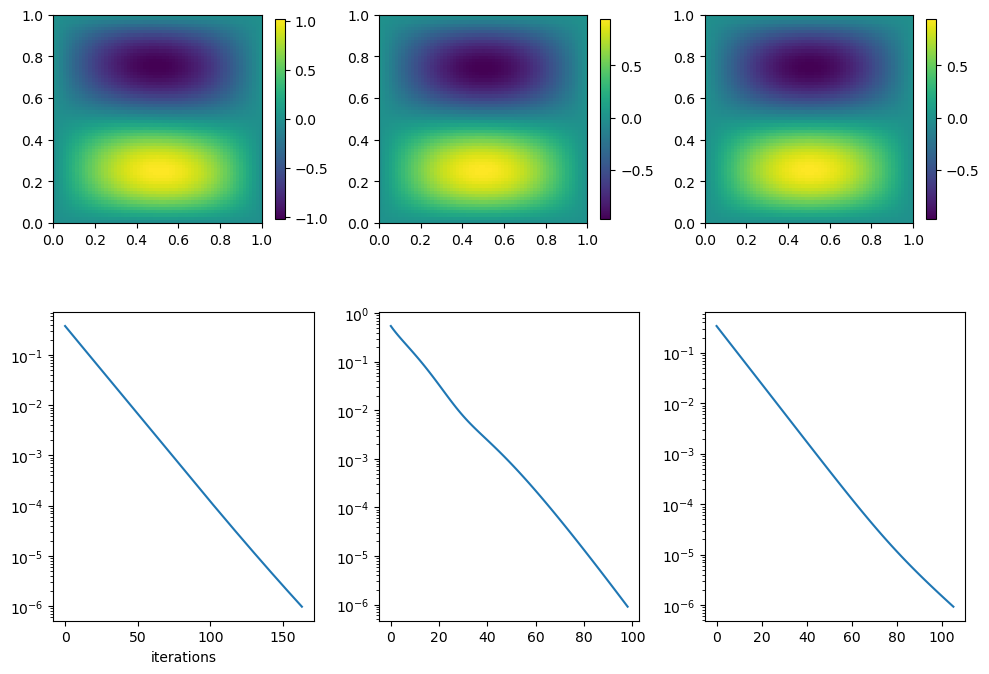

In [87]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (10,5))
fig.suptitle('')

im0 = ax[0][0].imshow(u_mgv_space[::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im0, ax=ax[0][0], shrink = 0.65)
im1 = ax[0][1].imshow(u_mgv_dom[::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im1, ax=ax[0][1], shrink = 0.65) 
im2 = ax[0][2].imshow(u_mgv_nor[::-1, :], extent=[0, 1, 0, 1])
fig.colorbar(im1, ax=ax[0][2], shrink = 0.65) 

ax[1][0].semilogy(res_space)
ax[1][0].set_xlabel('iterations')
ax[1][1].semilogy(res_dom)
ax[2][0].set_xlabel('iterations')
ax[1][2].semilogy(res_nor)
ax[1][2].set_xlabel('iterations')

plt.tight_layout(rect=[0, 0, 1, 1.5])  # Adjust layout to make room for the title
plt.show()